В этом домашнем задании две части:
* в первой части вы попрактикуетесь в использовании различных имплементаций бустинга
* во второй части потренируетесь снижать размерность с помощью метода главных компонент, а также используете методы кластеризации для задач компьютерного зрения

 # Часть 1. Бустинг

In [4]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## Прогнозируем задержки самолётов (3 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми подходами к обработке данных, а также методами градиентного бустинга (XGboost, catboost, LightGBM) и GridSearch для достижения результата. Получите 2 балла за преодоление порога roc_auc_score 0.72 на кросс-валидации и ещё 1 балл за преодоление порога 0.74.

За получение любого значения roc_auc_score < 0.72 (построение модели и вывод на экран некоторого числа) получаете 1 балл.

In [ ]:
#!pip install catboost==1.0.3
#!pip install lightgbm==3.2.1
#!pip install cmake==3.22.0 # без нее xgboost установится, но не будет импортироваться
#!pip install xgboost==1.5.0

In [5]:
import pandas as pd

data = pd.read_csv('flight_delays.csv')

In [9]:
data

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y
...,...,...,...,...,...,...,...,...,...
99995,c-5,c-4,c-3,1618,OO,SFO,RDD,199,N
99996,c-1,c-18,c-3,804,CO,EWR,DAB,884,N
99997,c-1,c-24,c-2,1901,NW,DTW,IAH,1076,N
99998,c-4,c-27,c-4,1515,MQ,DFW,GGG,140,N


In [7]:
import catboost
from catboost import CatBoostClassifier

In [11]:
X = data.iloc[:,:-1]
y = (data.dep_delayed_15min == 'Y').astype('int')

In [17]:
# Всего две численные колокнки, остальные 6 - категориальные

num = X.columns[X.dtypes == 'int64'].tolist()
num

['DepTime', 'Distance']

### Добавление новых категориальных признаков:

In [20]:
# Маршрут - направление от начального до конечного пункта

X['Route'] = X['Origin'] + "_" + X['Dest']

# Комбинация code of a company-career и flight origin
X['Carrier_Origin'] = X['UniqueCarrier'] + "_" + X['Origin']

In [21]:
# Видим, что имеется достаточно сильный дисбаланс классов

y.value_counts(normalize=True)

0    0.80956
1    0.19044
Name: dep_delayed_15min, dtype: float64

In [40]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, train_size=0.8, 
                                            shuffle=True, random_state=33)

In [57]:
# Воспользуемся встроенным в библиотеку Catboost грид-сёрчем

cat_features = ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'Route', 'Carrier_Origin']

params_grid = {'l2_leaf_reg': np.arange(1, 10, 2),
             'depth': np.arange(2, 12, 2)}

clf1_grid = CatBoostClassifier(eval_metric='AUC', logging_level='Silent', cat_features=cat_features, early_stopping_rounds=20,
                               learning_rate=0.1, thread_count=-1)

search_results = clf1_grid.grid_search(params_grid , X_tr, y_tr, cv=3)

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.7434130	best: 0.7434130 (0)	total: 10.1s	remaining: 4m 2s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.7431004	best: 0.7434130 (0)	total: 21s	remaining: 4m 1s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.7429751	best: 0.7434130 (0)	total: 30.7s	remaining: 3m 44s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.7405148	best: 0.7434130 (0)	total: 39.5s	remaining: 3m 27s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
4:	loss: 0.7415573	best: 0.7434130 (0)	total: 50.4s	re

In [58]:
# Результаты кросс-валидации

search_results['params']

{'depth': 6, 'l2_leaf_reg': 7}

In [59]:
# Обучим градиентный бустинг

cb_grid = CatBoostClassifier(eval_metric='AUC', logging_level='Silent', cat_features=cat_features,
                             early_stopping_rounds=40, learning_rate=0.1, depth=6, l2_leaf_reg=7, rsm=1.0)
cb_grid.fit(X_tr, y_tr, eval_set=(X_val, y_val), cat_features=cat_features, use_best_model=True, verbose=False);

In [60]:
# Измерим качество на кросс-валидации

from sklearn.model_selection import cross_val_score

score = cross_val_score(cb_grid, X, y, cv=3, scoring='roc_auc')

print('AUC-ROC на кроссвалидации составляет:', score.mean())

AUC-ROC на кроссвалидации составляет: 0.7636433757566824


**Алгоритм**: Catboost

**Мотивация выбранного алгоритма**: в датасете очень много категориальных признаков. Catboost умеет хорошо работать с категориями, а именно самостоятельно их обрабатывать, причём оптимальным образом. Поэтому их трёх бустингов стоит присмотреться именно к нему.

 # Часть 2. Обучение без учителя.

## Задание 1. Кластеризация (3 балла)

Задача [кластеризации](https://en.wikipedia.org/wiki/Cluster_analysis) данных является одним из примеров задач обучения "без учителя". Она заключается в разбиении множества объектов на заданное число кластеров, при этом предполагается, что внутри одного кластера будут находиться похожие между собой объекты. Одним из примеров методов кластеризации является алгоритм [KMeans](https://en.wikipedia.org/wiki/K-means_clustering).

### Выбор числа кластеров

Для некоторых алгоритмов кластеризации число кластеров является гиперпараметром (например, в случае KMeans). Поэтому для выбора количества кластеров может быть испоьзован следующий подход: при фиксированной метрики качества для разного числа кластеров вычисляют кластеризацию и выбирают то значение, начиная с которого качество "стабилизируется".

### Метрики качества

Оценивание качества построенной кластеризации не всегда тривиальная задача, так как следует учитывать такие факты как:
 - объекты одного класса должны быть более похоже, чем объекты других кластеров, относительно некоторой заданной метрики похожести
 - метрика не должна учитывать абсолютные значения меток объектов, попавших в кластер (в случае, если истинные метоки известны)

При выполнении задания для оценки качества получившейся кластеризации воспользуемся следующими метриками:
 - [Homogeneity и Completeness](http://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness-and-v-measure) 
 - [Adjusted Rand index](http://scikit-learn.org/stable/modules/clustering.html#adjusted-rand-index) 
 - [Silhouette Coefficient](http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)

Загрузите набор данных [digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html). Перед применением алгоритмов не забудьте перемешать изображения в случайном порядке.

In [6]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits = load_digits()
X, y = digits.data, digits.target
Im = digits.images

In [10]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=0)

Кластеризуйте изображения при помощи алгоритма [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), подобрав число кластеров для некоторой фиксированной метрики из указанных выше. Рассмотрите различные способы выбора начального приближения (параметр *init*). Оцените качество получившейся кластеризации используя все описанные выше метрики. Визуализируйте изображения, соответствующие центроидам лучшей кластеризации.

In [7]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
import numpy as np
import random

from matplotlib import pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
def kmeans_clust(X, y, init):
    
    labels = y
    score = []
    all_clusters = np.arange(3, 11, 1)
    print(f'Для init: {init}:\n')

    for clusters in all_clusters:
        
        km = KMeans(n_clusters=clusters, init=init, max_iter=200, n_init=1, random_state=29)
        km.fit(X)
        score.append(metrics.homogeneity_score(labels, km.labels_))
        print(f'Homogeneity при {clusters} кластеров составляет %0.3f' % metrics.homogeneity_score(labels, km.labels_))
   
    optim_cluster = all_clusters[np.argmax(score)] 
    print('')
    print(f'Оптимальное число кластеров: {optim_cluster}')
    
    km_opt = KMeans(n_clusters=optim_cluster, init=init, max_iter=200, n_init=1, random_state=29)
    km_opt.fit(X)
    
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km_opt.labels_))
    print("Completeness: %0.3f" % metrics.completeness_score(labels, km_opt.labels_))
    print("Adjusted Rand-Index: %0.3f" % metrics.adjusted_rand_score(labels, km_opt.labels_))
    print("Silhouette: %0.3f" % metrics.silhouette_score(X, km_opt.labels_, metric='euclidean'))
    
    _, axes = plt.subplots(2, 5)
    for ax, center in zip(axes.ravel(), km_opt.cluster_centers_):
        ax.matshow(center.reshape(8, 8), cmap=plt.cm.gray)
        ax.set_xticks(())
        ax.set_yticks(())

Для init: k-means++:

Homogeneity при 3 кластеров составляет 0.231
Homogeneity при 4 кластеров составляет 0.362
Homogeneity при 5 кластеров составляет 0.451
Homogeneity при 6 кластеров составляет 0.510
Homogeneity при 7 кластеров составляет 0.583
Homogeneity при 8 кластеров составляет 0.638
Homogeneity при 9 кластеров составляет 0.692
Homogeneity при 10 кластеров составляет 0.701

Оптимальное число кластеров: 10
Homogeneity: 0.701
Completeness: 0.732
Adjusted Rand-Index: 0.577
Silhouette: 0.187


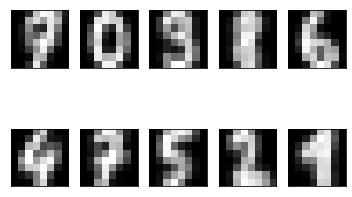

In [7]:
kmeans_clust(X, y, 'k-means++')

Для init: random:

Homogeneity при 3 кластеров составляет 0.298
Homogeneity при 4 кластеров составляет 0.329
Homogeneity при 5 кластеров составляет 0.406
Homogeneity при 6 кластеров составляет 0.520
Homogeneity при 7 кластеров составляет 0.590
Homogeneity при 8 кластеров составляет 0.595
Homogeneity при 9 кластеров составляет 0.666
Homogeneity при 10 кластеров составляет 0.714

Оптимальное число кластеров: 10
Homogeneity: 0.714
Completeness: 0.741
Adjusted Rand-Index: 0.610
Silhouette: 0.185


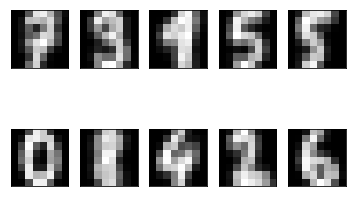

In [8]:
kmeans_clust(X, y, 'random')

**Вывод**:

В целом, кластеризация получилась хорошо, мы получили вполне себе теоретический результат - всего кластеров 10 (так как у нас 10 различных цифр) по инициализации 'k-means++'. По всем метрикам, кроме Silhouette, качество вышло очень высокое. Что касается Silhouette, то такой результат тоже ожидаем, потому что это внутренняя метрика и считается она без использования меток объектов, а сами объекты довольно низкого качества (каждая картинка - 8х8 пикселей и чёрно-белая) поэтому сложно евклидовой метрикой получить что-то более осмысленное. Что касается инициализации 'random', то качество чуть хуже, чем у 'k-means++', но отличается несильно.

In [9]:
def clusters_centers(data, num_clusters, init0):
    estimator = KMeans(init=init0, n_clusters=num_clusters)
    estimator.fit(data)
    
    centers = estimator.cluster_centers_
    for elem in centers:
        elem = elem.reshape((8,8))
        plt.imshow(elem, interpolation='none')
        plt.show()

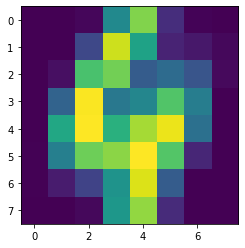

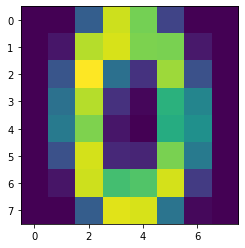

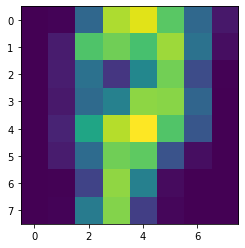

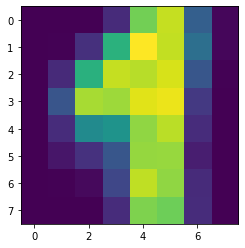

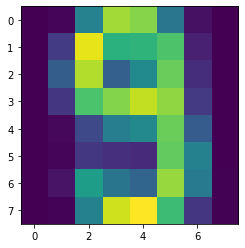

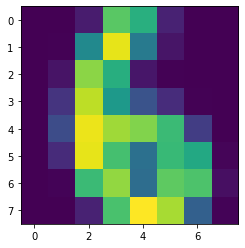

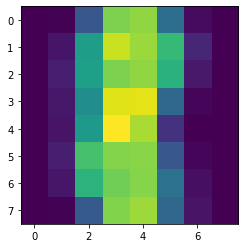

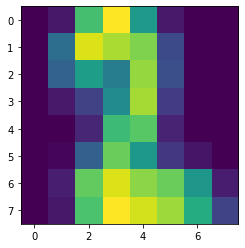

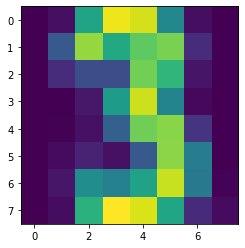

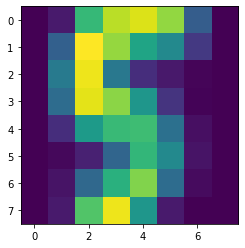

In [10]:
clusters_centers(X, 10, 'k-means++')

**Вывод**:

По сути сделал всё еще в предыдущем задании, тут лишь повторил результат. Ещё раз скажу, что кластеров 10, как и цифр в нашем датасете, при этом сами кластеры довольно "осмысленные", можно разглядеть все 10 цифр. Лучшее качество показывает инициализаци 'k-means++'.

Не всегда бывает удобно работать с полной матрицей объект-признак, например, для случая визуализации данных. Можно применить метод уменьшения размерности *PCA*. Вот [здесь](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#example-manifold-plot-lle-digits-py) было показано сравнение различных способов сжатия размерности для проекции на плоскость. На изображениях видно, что некоторые преобразования дают неплохую картину и одинаковые цифры расположены близко друг к другу. Посмотрим, поможет ли это на практике.
 
Примените преобразования [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) и [tSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (для числа компонент 2 и 10) и сравните результаты с предыдущими. Нашелся ли метод кластеризации, превосходящий другие по всем метрикам? Являются ли все три метрики согласованными? Можете ли вы объяснить почему?

In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Про визуализацию 10 компонент: нельзя визуализировать на плоскости :) но это и не требуется, поэтому визуализирую только для 2-х компонент в обоих случаев

In [12]:
def pca_kmeans(X, y):
    
    components = [2, 10]
    labels = y
    
    for comp in components:
        
        pca = PCA(n_components=comp)
        X_pca = pca.fit_transform(X)

        km = KMeans(init='k-means++', n_clusters=10)
        km.fit(X_pca)
        
        print(f'Для случая с {comp} компонентами:')
        print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
        print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
        print("Adjusted Rand-Index: %0.3f" % metrics.adjusted_rand_score(labels, km.labels_))
        print("Silhouette: %0.3f" % metrics.silhouette_score(X, km.labels_, metric='euclidean'))
        
        if comp == 2:
            plt.scatter(X_pca[:,0], X_pca[:,1], c=km.labels_, s=50, cmap='viridis', label=comp)
            plt.legend()
            plt.show()

Для случая с 2 компонентами:
Homogeneity: 0.524
Completeness: 0.528
Adjusted Rand-Index: 0.396
Silhouette: 0.083


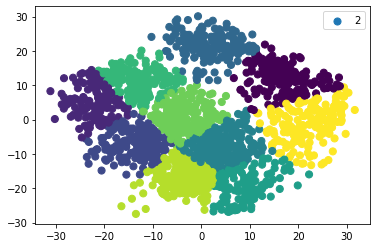

Для случая с 10 компонентами:
Homogeneity: 0.725
Completeness: 0.734
Adjusted Rand-Index: 0.653
Silhouette: 0.181


In [13]:
pca_kmeans(X, y)

In [269]:
def tsne_kmeans(X, y):
    
    components = [2, 10]
    labels = y
    
    for comp in components:
        
        tsne = TSNE(method='exact', n_components=comp, random_state=21)
        X_tsne = tsne.fit_transform(X) 

        km = KMeans(init='k-means++', n_clusters=10)
        km.fit(X_tsne)
        
        print(f'Для случая с {comp} компонентами:')
        print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
        print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
        print("Adjusted Rand-Index: %0.3f" % metrics.adjusted_rand_score(labels, km.labels_))
        print("Silhouette: %0.3f\n" % metrics.silhouette_score(X, km.labels_, metric='euclidean'))

        if comp == 2:
            plt.figure(figsize=(12,10))
            plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
                    edgecolor='none', alpha=0.7, s=40,
                    cmap=plt.cm.get_cmap('nipy_spectral', 10), label=comp)
            plt.legend()
            plt.colorbar()
            plt.title('MNIST. t-SNE projection');

Для случая с 2 компонентами:
Homogeneity: 0.909
Completeness: 0.911
Adjusted Rand-Index: 0.887
Silhouette: 0.160

Для случая с 10 компонентами:
Homogeneity: 0.827
Completeness: 0.833
Adjusted Rand-Index: 0.769
Silhouette: 0.175



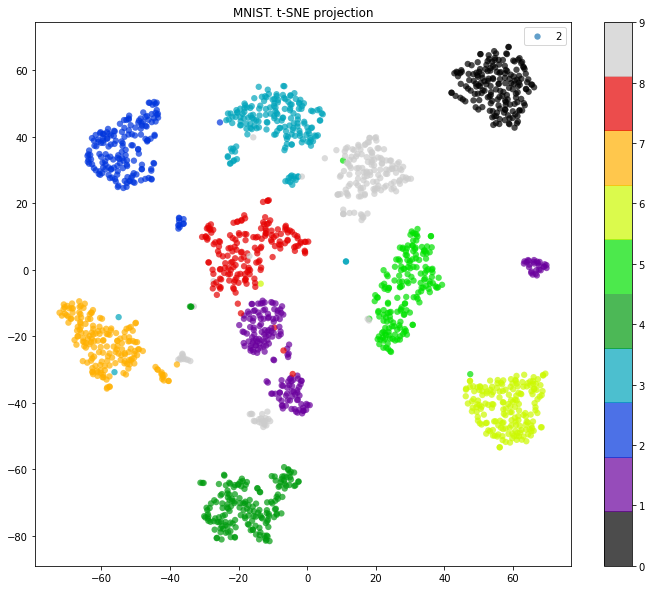

In [270]:
tsne_kmeans(X, y)

**Вывод**:

1. PCA

PCA сработал довольно быстро, при этом в случае двух компонент качество упало по всем метрикам, поскольку ему при таком низком количестве компонент алгоритму K-means не хватало информации для осмысленной кластеризации. В случае PCA с 10 компонентами, ситуация практически не изменилась от той, что была при использовании K-means без PCA (метрики остались на том же уровне).

2. tSNE

В случае tSNE с 2 компонентами наоборот, качество всех метрик увеличилось практически на 0.2, что достаточно существенно. При этом по визуализации можно заметить, что все объекты расположены практически идеально по кластерам, при этом можно заметить несколько "выбросов" - в нашем случае те цифры, которые, видимо, отличаются от своего класса необычной формой. tSNE с 10 компонентами немного снизил качество (хотя всё равно лучше, чем у PCA), видимо из-за некоторого переобучения в том смысле, что пытается доставать инфомрации больше, чем реально можно "выжать" из компонент.

Метрики в среднем согласованы, но иногда бывают расхождения, поскольку разные метрики смотрят на разные индикаторы (во-первых есть внешние, которые сравнивают с меткой классой, и внутренние, которые работают по неразмеченным данным)

Визуализируйте несколько изображений, которые во всех случаях были отнесены к неправильному кластеру (объект назовем ошибочно отнесенным, если он имеет иную метку класса, нежели большая часть объектов в кластере). Можете ли вы пояснить почему так произошло?

In [14]:
tsne = TSNE(method='exact', n_components=2, random_state=21)
X_tsne = tsne.fit_transform(X) 

km_opt = KMeans(init='k-means++', n_clusters=10)
km_opt.fit(X_tsne)

print(f'Для случая с {2} компонентами:')
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, km_opt.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(y, km_opt.labels_))
print("Adjusted Rand-Index: %0.3f" % metrics.adjusted_rand_score(y, km_opt.labels_))
print("Silhouette: %0.3f\n" % metrics.silhouette_score(X, km_opt.labels_, metric='euclidean'))

Для случая с 2 компонентами:
Homogeneity: 0.902
Completeness: 0.903
Adjusted Rand-Index: 0.878
Silhouette: 0.163



Номер объекта 705
Реальные классы: 9
Кластеризированные метки: 8


<Figure size 432x288 with 0 Axes>

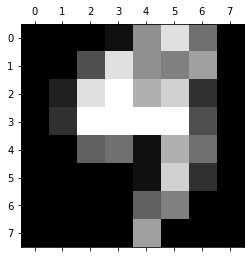

Номер объекта 1510
Реальные классы: 7
Кластеризированные метки: 2


<Figure size 432x288 with 0 Axes>

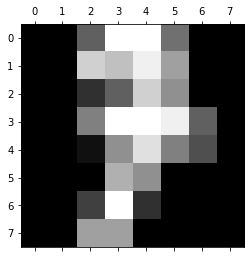

Номер объекта 551
Реальные классы: 7
Кластеризированные метки: 2


<Figure size 432x288 with 0 Axes>

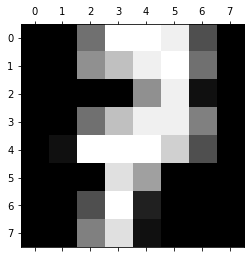

In [66]:
np.random.seed(123)

for i in range(3):
    rand = np.random.choice(y.shape[0])
    if y[rand] != km_opt.labels_[rand]:
        print(f'Номер объекта {rand}')
        print(f'Реальные классы: {y[rand]}')
        print(f'Кластеризированные метки: {km_opt.labels_[rand]}')

        plt.gray()
        plt.matshow(X.reshape(-1, 8, 8)[rand])
        plt.show()

**Вывод**:

Как видно из нарисованных чисел, метка класса не совпадает в случаях, когда сама картинка (и её числовое описание) сильно отличается от центров кластеров. Такое вполне может быть, поскольку некоторые цифры очень похожи по форме друг на друга, а потому алгоритм может легко ошибиться в таком случае.

## Задание 2. Разделение изображения на семантические компоненты (4 балла)

![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. 

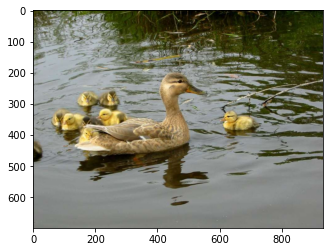

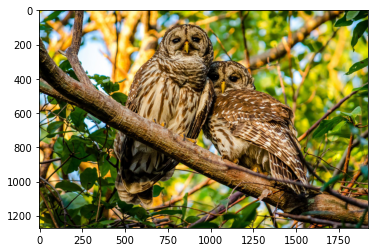

In [8]:
from sklearn.cluster import KMeans

image1 = imread("duck.jpg")
plt.imshow(image1)
plt.show()
image2 = imread("owls.jpg")
plt.imshow(image2)
plt.show()

Для каждого изображения, используя кластеризацию KMeans, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$, где 
$x_i$ и $y_i$ — координаты пикселя, $r_i, g_i, b_i$ — его цвет, $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

In [49]:
def find_components(image, lmbd, n_clusters):
    
    psi = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
             psi.append([lmbd * i, lmbd * j, image[i][j][0], image[i][j][1], image[i][j][2]])
    
    kmeans = KMeans(n_clusters = n_clusters)
    kmeans.fit(psi)
    
    return kmeans.labels_

In [64]:
lab1 = find_components(image1, 0.3, 3)

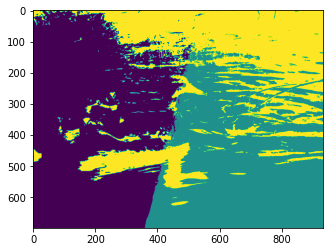

In [65]:
plt.imshow(lab1.reshape(700, 933))
plt.show()

In [39]:
lab2 = find_components(image2, 0.3, 3)

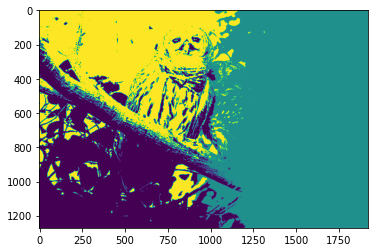

In [40]:
plt.imshow(lab2.reshape(1271, 1920))
plt.show()

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html). Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

In [39]:
import skimage
from skimage import transform
from skimage import color
from sklearn.feature_extraction.image import img_to_graph
from sklearn.cluster import spectral_clustering

def spectral_segmentation(image, n_clusters, method, beta=5, eps=1e-6):
    
    graph = img_to_graph(image)
    graph.data = np.exp(-beta * graph.data / image.std()) + eps
    
    t0 = time.time()
    labels = spectral_clustering(graph, n_clusters=n_clusters,
                                 assign_labels=method)
    
    t1 = time.time()
    labels = labels.reshape(image.shape)

    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap=plt.cm.gray)
    for l in range(n_clusters):
            plt.contour(labels == l, contours=1,
                    colors=[plt.cm.Spectral(l / float(n_clusters)), ])
    plt.xticks(())
    plt.yticks(())
    plt.title('Spectral clustering: %s, %.2fs' % (method, (t1 - t0)))

    plt.show()

Визуализируйте результаты сегментации (аналогично рисунку выше) для обоих методов.

In [44]:
image11 = skimage.color.rgb2gray(image1)
rows, cols = image1.shape[0], image1.shape[1]
image11 = skimage.transform.resize(image11,(int(0.5*rows),int(0.5*cols)))

image22 = skimage.color.rgb2gray(image2)
rows, cols = image2.shape[0], image2.shape[1]
image22 = skimage.transform.resize(image22,(int(0.5*rows),int(0.5*cols)))

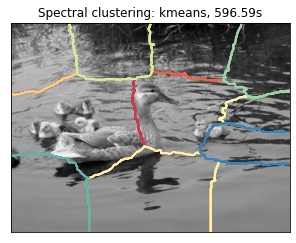

In [46]:
spectral_segmentation(image11, 11, 'kmeans')

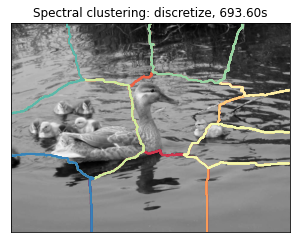

In [45]:
spectral_segmentation(image11, 11, 'discretize')

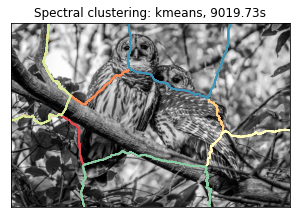

In [47]:
spectral_segmentation(image22, 8, 'kmeans')

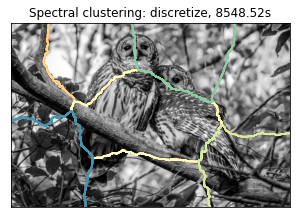

In [48]:
spectral_segmentation(image22, 8, 'discretize')

Поэкспериментируйте с параметрами алгоритмов. Сравните два подхода и сегментации, к которым они приводят.
Для всех ли изображений в результате сегментации хорошо видны контуры объектов?

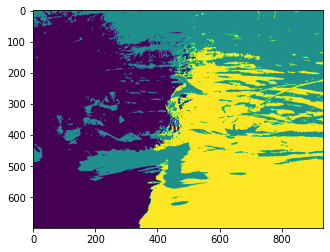

In [70]:
# Меньше лямбда - менее четкие контуры между слоями

lab1 = find_components(image1, 0.2, 3)
plt.imshow(lab1.reshape(700, 933))
plt.show()

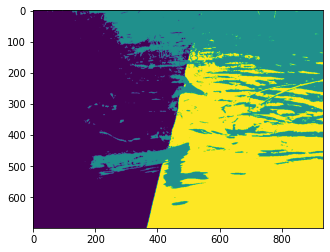

In [71]:
# Больший лямбда - более четкие контуры между слоями

lab1 = find_components(image1, 0.4, 3)
plt.imshow(lab1.reshape(700, 933))
plt.show()

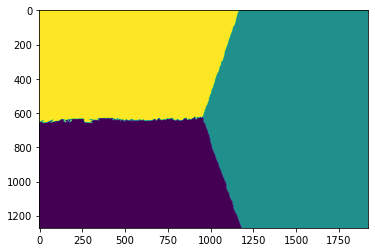

In [73]:
# При очень большом лямбда картинка вовсе теряется

lab2 = find_components(image2, 1.5, 3)
plt.imshow(lab2.reshape(1271, 1920))
plt.show()

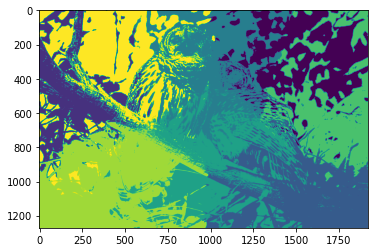

In [74]:
# При большом количестве кластеров появляется больше слоев 

lab2 = find_components(image2, 0.3, 8)
plt.imshow(lab2.reshape(1271, 1920))
plt.show()

**Выводы**:

Первый подход на основе K-Means работает быстро, при этом при хорошем подборе параметров (что делается довольно несложно) можно получить качественные результаты. 

Второй подход на основе спектральной сегментации очень затратен в плане ресурсов, работает долго и даёт сомнительные результаты.

При этом контуры объектов видны далеко не для всех изображений. Особенно это заметно для спектральной сегментации (полосы проводятся довольно неосмысленно). Возможная причина - слишком большой размер картинки, алгоритмам не хватает мощности чтобы получить что-то осмысленное, хотя некоторые детали (ветки, крыло совы) всё же находятся.